## NEW CODE 

In [40]:
!pip install psutil
!pip install pylatexenc
!pip install MatPlotLib

# Quantum Amplitude Estimator Algorithm 

The details of this algorithm is detailed in the report

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from qiskit import QuantumCircuit, transpile
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit_aer import AerSimulator
import time
import logging
import psutil

logging.basicConfig(level=logging.INFO)

def log_memory_usage(stage):
    memory = psutil.virtual_memory()
    logging.info(f"{stage} - Memory usage: {memory.percent}%")

# Define Black-Scholes Parameters
S, vol, r, T, strike_price = 2, 0.1, 0.04, 300 / 365, 2
mu, sigma = (r - 0.5 * vol**2) * T + np.log(S), vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)
low, high = np.maximum(0, mean - 3 * stddev), mean + 3 * stddev

# Simulate Log-Normal Distribution
num_uncertainty_qubits = 3  # Start with 3 qubits for stability
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

#  Define the Payoff Function
c_approx = np.sqrt(2) * 2**(-num_uncertainty_qubits / 3)
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min, f_max = 0, high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

INFO:qiskit.passmanager.base_tasks:Pass: UnrollCustomDefinitions - 0.25296 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 2.06208 (ms)


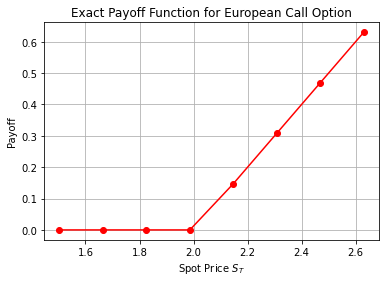

In [3]:
# Plot exact payoff function
payoff = np.maximum(0, uncertainty_model.values - strike_price)
plt.plot(uncertainty_model.values, payoff, "ro-")
plt.grid()
plt.xlabel("Spot Price $S_T$")
plt.ylabel("Payoff")
plt.title("Exact Payoff Function for European Call Option")
plt.show()



In [4]:
#  Multilevel Framework
levels, num_paths = 5, 1000
M = [2**l for l in range(levels)]

def euler_maruyama(S0, r, sigma, T, M):
    dt = T / M
    paths = [S0]
    for _ in range(M):
        Z = np.random.normal()
        S_next = paths[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        paths.append(S_next)
    return paths[-1]

def generate_paths(M_level, num_paths):
    return [euler_maruyama(S, r, vol, T, M_level) for _ in range(num_paths)]

In [13]:
print(M)

[1, 2, 4, 8, 16]


In [5]:
# Compute payoffs and differences
payoffs, differences = {}, {}
for level in range(levels):
    paths = generate_paths(M[level], num_paths)
    payoffs[level] = [max(0, path - strike_price) for path in paths]
    if level > 0:
        differences[level] = np.array(payoffs[level]) - np.array(payoffs[level - 1])

# Initialize AerSimulator without passing it to the Sampler
simulator = AerSimulator()

# Initialize the Sampler correctly
sampler = Sampler(run_options={"shots": 100})
quantum_estimates = []

for level in range(levels):
    try:
        log_memory_usage(f"Before Level {level}")
        data = payoffs[level] if level == 0 else differences[level]

        problem = EstimationProblem(
            state_preparation=uncertainty_model,
            objective_qubits=[num_uncertainty_qubits -1],
            post_processing=lambda x: np.mean(data),
        )
        ae = IterativeAmplitudeEstimation(
            epsilon_target=0.15,
            alpha=0.05,
            sampler=sampler,
        )
        result = ae.estimate(problem)
        quantum_estimates.append(result.estimation_processed)
        log_memory_usage(f"After Level {level}")
    except MemoryError as e:
        logging.error(f"MemoryError at level {level}: {e}")
        break
    except Exception as e:
        logging.error(f"Error at level {level}: {e}")
        quantum_estimates.append(None)

# Combine estimates using MLMC telescoping sum
mlmc_estimate = sum(filter(None, quantum_estimates))

INFO:root:Before Level 0 - Memory usage: 61.6%
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.02193 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01502 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1.84011 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.14997 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ElidePermutations - 0.03195 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveDiagonalGatesBeforeMeasure - 0.04506 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveIdentityEquivalent - 0.07701 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.17190 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutativeCancellation - 0.19097 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ConsolidateBlocks - 1.91903 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Split2QUnitaries - 0.01884 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01574 (ms)
INFO:qiskit.passmanager.base_tasks:Pa

Black-Scholes Price: 0.10810752824797865
MLMC Quantum Estimate: 0.11740240370888964


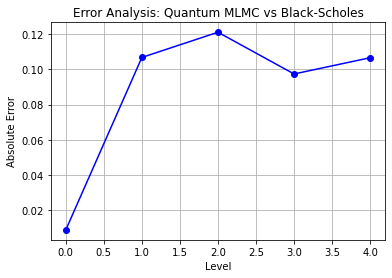

In [6]:
# Compare with Black-Scholes Price
def black_scholes(S, sigma, r, T, K):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

bs_price = black_scholes(S, vol, r, T, strike_price)
print(f"Black-Scholes Price: {bs_price}")
print(f"MLMC Quantum Estimate: {mlmc_estimate}")

# Step 8: Error Analysis
errors = [abs(bs_price - q) if q is not None else None for q in quantum_estimates]
plt.plot(range(levels), errors, "bo-")
plt.grid()
plt.xlabel("Level")
plt.ylabel("Absolute Error")
plt.title("Error Analysis: Quantum MLMC vs Black-Scholes")
plt.show()


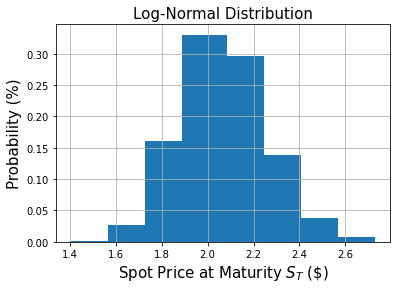

In [7]:

# Plot the log-normal distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability (%)", size=15)
plt.title("Log-Normal Distribution", size=15)
plt.show()


In [8]:
# Core Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import time
import logging
import psutil  # For memory usage monitoring (optional)

# Qiskit Libraries
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_finance.circuit.library import LogNormalDistribution


In [9]:
# Ensure total number of qubits includes ancillae
total_qubits = european_call_objective.num_qubits
quantum_circuit = QuantumCircuit(total_qubits)
print(total_qubits)

7


Quantum Circuit for European Call Option:


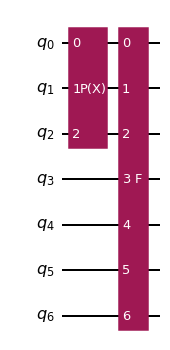

In [10]:


# Append components with correct qubit ranges
quantum_circuit.append(uncertainty_model, range(num_uncertainty_qubits))
quantum_circuit.append(european_call_objective, range(total_qubits))


print("Quantum Circuit for European Call Option:")
quantum_circuit.draw(output='mpl')  


# Monte Carlo Algo

In [11]:
import numpy as np
import time

def monte_carlo_european_call(S, K, r, sigma, T, num_paths):
    np.random.seed(42)  # For reproducibility
    dt = T
    Z = np.random.normal(size=num_paths)
    S_T = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    payoffs = np.maximum(S_T - K, 0)
    discounted_payoff = np.exp(-r * T) * np.mean(payoffs)
    return discounted_payoff


# Runtime comparison between Monte Carlo and Q MLMC Algo

In [20]:
# Define parameters
S, K, r, sigma, T = 2, 2, 0.04, 0.1, 300/365
num_paths = 1000  # Number of Monte Carlo simulations


# Measure runtime and calculate prices
# Monte Carlo
start = time.time()
mc_price = monte_carlo_european_call(S, K, r, sigma, T, num_paths)
mc_runtime = time.time() - start

# Quantum Monte Carlo (assumed implemented earlier)
start = time.time()
qmc_price = mlmc_estimate  # Assuming `mlmc_estimate` from quantum algorithm
qmc_runtime = time.time() - start

# Create a comparison table
import pandas as pd

results = pd.DataFrame({
    "Algorithm": ["Monte Carlo", "Quantum Monte Carlo"],
    "Price Estimate": [mc_price, qmc_price],
    "Runtime (seconds)": [mc_runtime,  qmc_runtime]
})

print(results)

             Algorithm  Price Estimate  Runtime (seconds)
0          Monte Carlo        0.108729           0.000621
1  Quantum Monte Carlo        0.117402           0.000064


The runtime for the quantum Algorithm is 100 times faster which is logic since our epsilon target is :  0.15. 